Note: you may need to restart the kernel to use updated packages.
Current Folder: /Users/rjoshi_24/Desktop/CPI_Project
Target File: CPI_CAD30YR.csv
✅ File found. Starting analysis...
Data Loaded: 365 months (1995-06-01 to 2025-10-01)


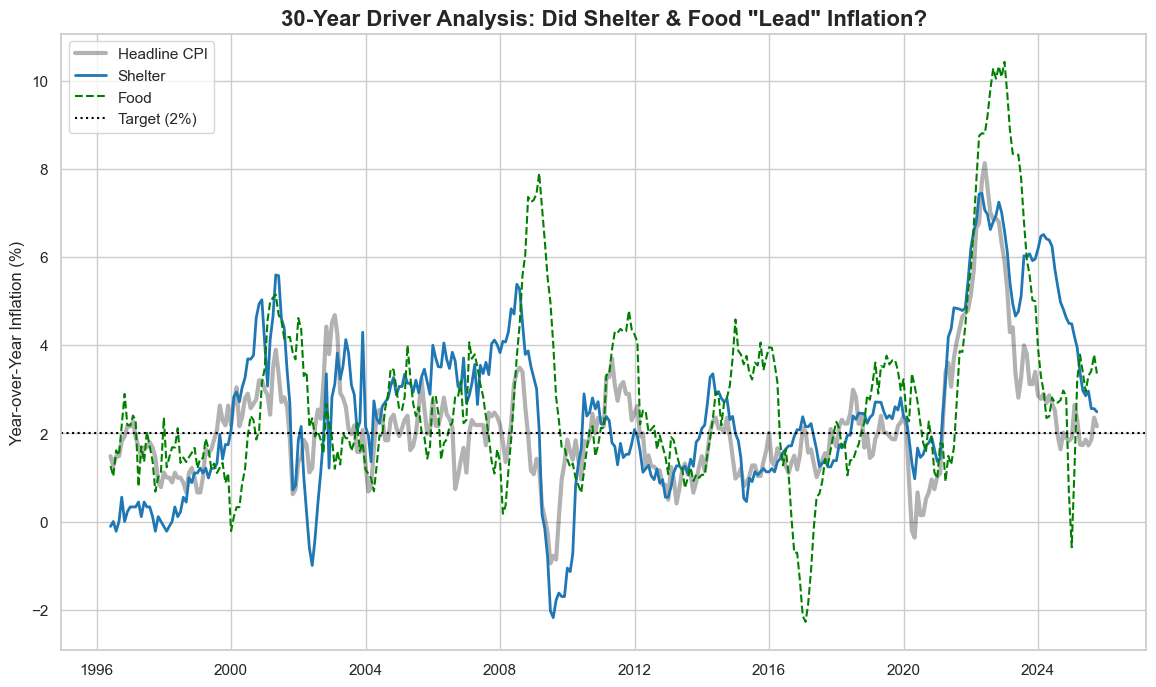

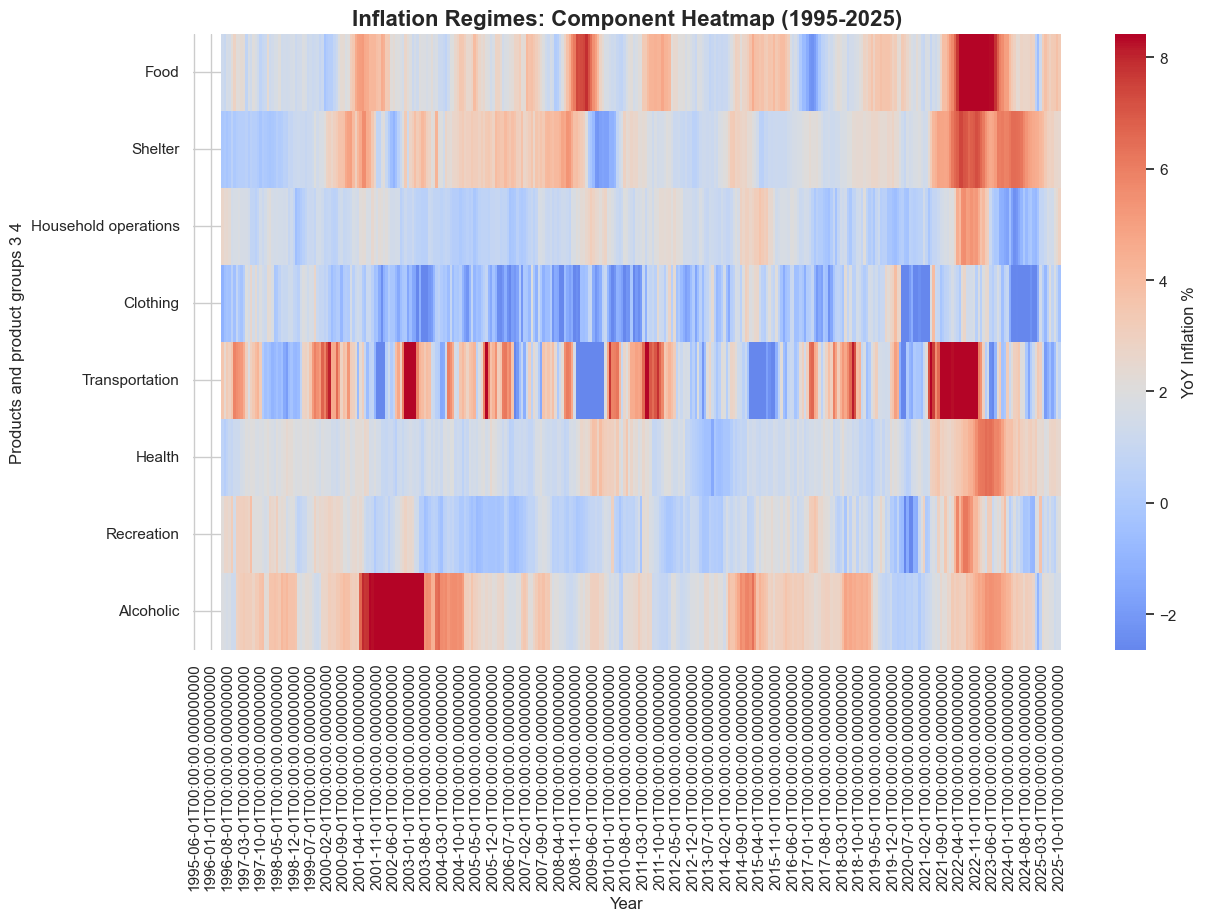

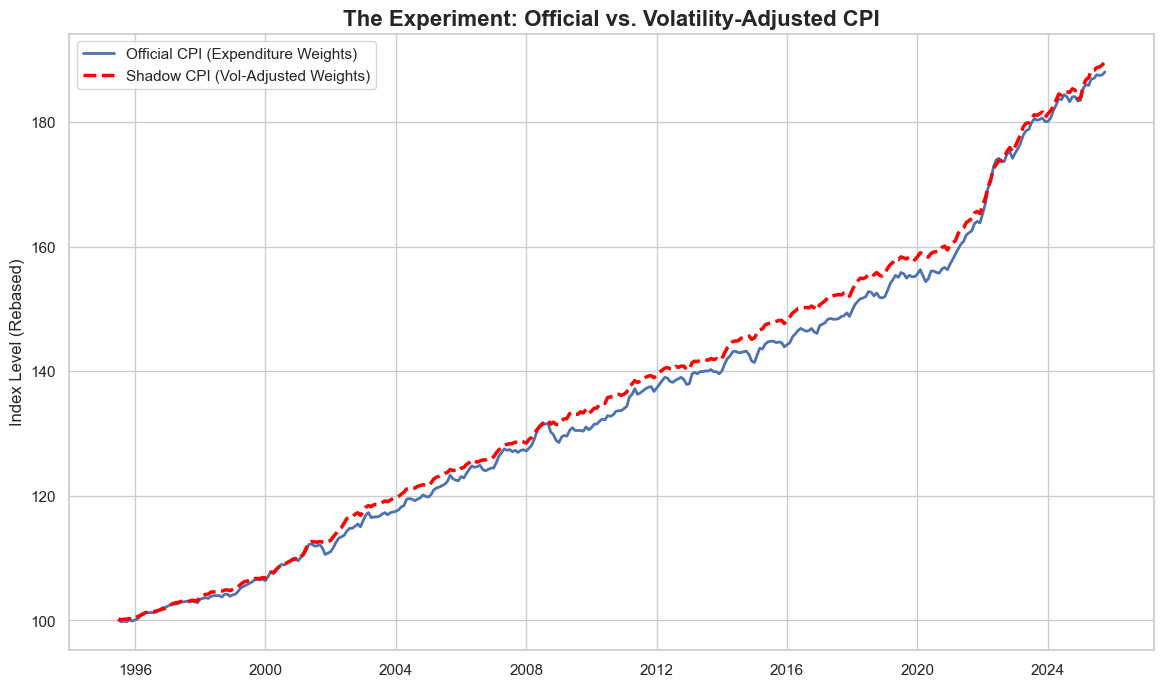


EXECUTIVE SUMMARY (October 2025)
1. WHO LED? (Shelter Analysis)
   - 30-Year Avg Shelter Inflation: 2.516%
   - 30-Year Avg Headline Inflation: 2.135%
   -> YES. Shelter has structurally run hotter than headline.
--------------------------------------------------
2. THE SHADOW INDEX (Current Signal)
   - Official Inflation: 2.163%
   - Shadow Inflation:   2.336%
   - Divergence:         +0.173 bps

CONCLUSION: 'Real' Signal is HOTTER than Official.
Inflation is sticky in stable components. Hawkish signal.


In [8]:
"""
Project: 30-Year CPI Deep Dive & Volatility-Adjusted Model
Author: Raghav Joshi
Date: November 2025
Data Source: Statistics Canada Table 18-10-0004-01 (1995-2025)

Objectives:
1. Trend Analysis: Did Shelter/Food "lead" inflation over the last 30 years?
2. Shadow Index: Construct a Volatility-Adjusted CPI to strip out idiosyncratic shocks.
"""

%pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 0. CONFIGURATION
# ==========================================
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 16

# File Path Logic
FILENAME = 'CPI_CAD30YR.csv'
print(f"Current Folder: {os.getcwd()}")
print(f"Target File: {FILENAME}")

if not os.path.exists(FILENAME):
    print("\n❌ ERROR: File not found!")
    print("TIP: Ensure 'CPI_CAD30YR.csv' is in this folder.")
else:
    print("✅ File found. Starting analysis...")

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
try:
    # Read with header=8 (Line 9) to capture dates
    raw_df = pd.read_csv(FILENAME, header=8)
    
    # Set Index
    raw_df.set_index(raw_df.columns[0], inplace=True)
    
    # Transpose
    df = raw_df.T

    # --- THE FIX: Convert columns to strings to avoid "float" error ---
    df.columns = df.columns.astype(str)
    # -----------------------------------------------------------------
    
    # Clean Index (Dates)
    df.index = df.index.str.strip()
    df.index = pd.to_datetime(df.index, format='%B %Y', errors='coerce')
    df = df[df.index.notnull()].sort_index()
    
    # Clean Column Names
    df.columns = df.columns.str.replace(r'\s\d', '', regex=True).str.strip()
    
    print(f"Data Loaded: {len(df)} months ({df.index.min().date()} to {df.index.max().date()})")

except Exception as e:
    print(f"CRITICAL ERROR: {e}")

# ==========================================
# 2. COMPONENT SETUP
# ==========================================
target_components = ['Food', 'Shelter', 'Household operations', 'Clothing', 
                     'Transportation', 'Health', 'Recreation', 'Alcoholic']

clean_map = {}
for target in target_components:
    match = [col for col in df.columns if target in col]
    if match: clean_map[match[0]] = target

headline_col = [col for col in df.columns if 'All-items' in col][0]

# Create DataFrames
df_components = df[clean_map.keys()].rename(columns=clean_map).astype(float)
df_headline = df[[headline_col]].rename(columns={headline_col: 'Official_CPI'}).astype(float)

# ==========================================
# 3. ANALYSIS A: WHO LED THE WAY? (30-Year Trends)
# ==========================================
# Calculate YoY Inflation for Components
yoy_components = df_components.pct_change(12) * 100
yoy_headline = df_headline.pct_change(12) * 100

# PLOT 1: Shelter & Food vs. Headline
# This answers Chris's Q: "Did they lead for 20 years?"
plt.figure(figsize=(14, 8))

# Headline (Grey/Black for context)
plt.plot(yoy_headline, label='Headline CPI', color='black', linewidth=3, alpha=0.3)

# Key Drivers (Colored)
plt.plot(yoy_components['Shelter'], label='Shelter', color='#1f77b4', linewidth=2)
plt.plot(yoy_components['Food'], label='Food', color='green', linewidth=1.5, linestyle='--')

plt.axhline(2, color='black', linestyle=':', label='Target (2%)')
plt.title('30-Year Driver Analysis: Did Shelter & Food "Lead" Inflation?', fontweight='bold')
plt.ylabel('Year-over-Year Inflation (%)')
plt.legend()
plt.show()

# PLOT 2: Inflation Heatmap (The "Regime" View)
# Visualizes which component was "Hot" (Red) in which year
plt.figure(figsize=(14, 8))
sns.heatmap(yoy_components.T, cmap='coolwarm', center=2, robust=True, cbar_kws={'label': 'YoY Inflation %'})
plt.title('Inflation Regimes: Component Heatmap (1995-2025)', fontweight='bold')
plt.xlabel('Year')
plt.show()

# ==========================================
# 4. ANALYSIS B: THE SHADOW INDEX (Vol-Adjusted)
# ==========================================
# 1. Calculate Volatility (Std Dev of Monthly Returns)
monthly_returns = df_components.pct_change().dropna()
volatility = monthly_returns.std()

# 2. Inverse Volatility Weights (High Vol = Low Weight)
inv_vol = 1 / volatility
stat_weights = inv_vol / inv_vol.sum()

# 3. Build Shadow Index
stat_monthly_inflation = (monthly_returns * stat_weights).sum(axis=1)
shadow_index = (1 + stat_monthly_inflation).cumprod() * 100

# Re-base Official to match start date
start_date = shadow_index.index[0]
official_index_rebased = (df_headline.loc[start_date:] / df_headline.loc[start_date].iloc[0]) * 100

# PLOT 3: Official vs Shadow Index (The Divergence)
plt.figure(figsize=(14, 8))
plt.plot(official_index_rebased, label='Official CPI (Expenditure Weights)', linewidth=2)
plt.plot(shadow_index, label='Shadow CPI (Vol-Adjusted Weights)', color='red', linestyle='--', linewidth=2.5)

plt.title('The Experiment: Official vs. Volatility-Adjusted CPI', fontweight='bold')
plt.ylabel('Index Level (Rebased)')
plt.legend()
plt.show()

# ==========================================
# 5. EXECUTIVE SUMMARY
# ==========================================
# Calculate YoY for the Shadow Index
shadow_yoy = shadow_index.pct_change(12) * 100
current_official = yoy_headline.iloc[-1].item()
current_shadow = shadow_yoy.iloc[-1]
spread = current_shadow - current_official

print("\n" + "="*50)
print(f"EXECUTIVE SUMMARY ({yoy_headline.index[-1].strftime('%B %Y')})")
print("="*50)
print(f"1. WHO LED? (Shelter Analysis)")
shelter_avg = yoy_components['Shelter'].mean()
headline_avg = yoy_headline['Official_CPI'].mean()
print(f"   - 30-Year Avg Shelter Inflation: {shelter_avg:.3f}%")
print(f"   - 30-Year Avg Headline Inflation: {headline_avg:.3f}%")
if shelter_avg > headline_avg:
    print("   -> YES. Shelter has structurally run hotter than headline.")
else:
    print("   -> NO. Shelter has tracked inline or lower.")

print("-" * 50)
print(f"2. THE SHADOW INDEX (Current Signal)")
print(f"   - Official Inflation: {current_official:.3f}%")
print(f"   - Shadow Inflation:   {current_shadow:.3f}%")
print(f"   - Divergence:         {spread:+.3f} bps")

if spread < 0:
    print("\nCONCLUSION: 'Real' Signal is COOLER than Official.")
    print("Volatile shocks are propping up the number. Dovish signal.")
else:
    print("\nCONCLUSION: 'Real' Signal is HOTTER than Official.")
    print("Inflation is sticky in stable components. Hawkish signal.")
print("="*50)